In [3]:
# !pip install tensorflow==2.10.0

# !pip install pandas-datareader==0.10.0

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-a

In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [2]:
print(data_reader.__version__)
print(tf.__version__)

0.10.0
2.10.0


In [35]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=3, model_name="AITrader"):

        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen = 2000)
        self.inventory = []
        self.model = self.model_builder()
        self.model_name = self.model.name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
  
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer="Adam")
        
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def batch_train(self, batch_size):

        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state)

        if not done:
            target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target[0][action] = reward

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [36]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [37]:
def stocks_price_format(n):
    if n < 0:
        return "- # {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

In [38]:
def dataset_loader(stock_name):

    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    close = dataset['Close']

    return close

In [39]:
def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
        
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))

    return np.array([state])

In [40]:
stock_name = "AAPL"
data = dataset_loader(stock_name).iloc[-50:]
data

Date
2022-08-30    158.910004
2022-08-31    157.220001
2022-09-01    157.960007
2022-09-02    155.809998
2022-09-06    154.529999
2022-09-07    155.960007
2022-09-08    154.460007
2022-09-09    157.369995
2022-09-12    163.429993
2022-09-13    153.839996
2022-09-14    155.309998
2022-09-15    152.369995
2022-09-16    150.699997
2022-09-19    154.479996
2022-09-20    156.899994
2022-09-21    153.720001
2022-09-22    152.740005
2022-09-23    150.429993
2022-09-26    150.770004
2022-09-27    151.759995
2022-09-28    149.839996
2022-09-29    142.479996
2022-09-30    138.199997
2022-10-03    142.449997
2022-10-04    146.100006
2022-10-05    146.399994
2022-10-06    145.429993
2022-10-07    140.089996
2022-10-10    140.419998
2022-10-11    138.979996
2022-10-12    138.339996
2022-10-13    142.990005
2022-10-14    138.380005
2022-10-17    142.410004
2022-10-18    143.750000
2022-10-19    143.860001
2022-10-20    143.389999
2022-10-21    147.270004
2022-10-24    149.449997
2022-10-25    152.33

In [41]:
window_size = 5
episodes = 100

batch_size = 8
data_samples = len(data) - 1

In [42]:
trader = AI_Trader(window_size)
print(1)
trader.model.summary()

1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                192       
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [43]:
total_pro = []
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)

    action = [0]
    total_profit = 0
    trader.inventory = []

    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
  
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0

        if action == 1: #Buying
            trader.inventory.append(data[t])
            print("AI Trader bought: ", stocks_price_format(data[t]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_price = trader.inventory.pop(0)

            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )

        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")
            total_pro.append(total_profit)
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))

Episode: 1/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 155.960007
AI Trader sold:  $ 163.429993  Profit: $ 7.469986
AI Trader bought:  $ 155.309998
AI Trader sold:  $ 152.369995  Profit: - # 2.940002
1/1 [==============================] - 0s 55ms/step


 20%|████████████████▉                                                                  | 9/44 [00:03<00:12,  2.86it/s]

AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▋                                                               | 10/44 [00:04<00:16,  2.08it/s]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 65ms/step


 25%|████████████████████▌                                                             | 11/44 [00:05<00:20,  1.65it/s]

AI Trader sold:  $ 152.740005  Profit: - # 4.159988
1/1 [==============================] - 0s 53ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:07<00:24,  1.33it/s]

AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 52ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:08<00:26,  1.15it/s]

AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 32ms/step


 32%|██████████████████████████                                                        | 14/44 [00:09<00:27,  1.08it/s]

AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:29,  1.00s/it]

1/1 [==============================] - 0s 54ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:31,  1.13s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:31,  1.16s/it]

AI Trader sold:  $ 138.199997  Profit: - # 12.229996
1/1 [==============================] - 0s 79ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:31,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:30,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:30,  1.28s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:18<00:30,  1.31s/it]

AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 53ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:20<00:28,  1.31s/it]

AI Trader sold:  $ 140.089996  Profit: - # 11.669998
1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:21<00:27,  1.31s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:23<00:28,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:24<00:25,  1.37s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:25<00:24,  1.35s/it]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:26<00:22,  1.31s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:28<00:20,  1.26s/it]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:29<00:18,  1.26s/it]

AI Trader sold:  $ 143.750000  Profit: $ 1.270004
1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:30<00:17,  1.28s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:32<00:17,  1.32s/it]

AI Trader sold:  $ 143.389999  Profit: - # 2.039993
1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:33<00:15,  1.29s/it]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:34<00:14,  1.31s/it]

AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:36<00:13,  1.35s/it]

AI Trader sold:  $ 152.339996  Profit: $ 11.919998
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:37<00:12,  1.37s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:38<00:11,  1.40s/it]

AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:40<00:09,  1.38s/it]

AI Trader sold:  $ 155.740005  Profit: $ 17.400009
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:41<00:08,  1.34s/it]

AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:42<00:06,  1.33s/it]

AI Trader sold:  $ 150.649994  Profit: $ 12.269989
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:44<00:05,  1.30s/it]

1/1 [==============================] - 0s 60ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:45<00:03,  1.31s/it]

AI Trader sold:  $ 138.880005  Profit: - # 3.529999
1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:47<00:02,  1.46s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:48<00:01,  1.39s/it]

########################
TOTAL PROFIT: 10.810012817382812
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:49<00:00,  1.13s/it]


Episode: 2/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:53,  1.24s/it]

AI Trader sold:  $ 154.460007  Profit: - # 1.500000
1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:49,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


  7%|█████▋                                                                             | 3/44 [00:03<00:50,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:50,  1.27s/it]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:49,  1.28s/it]

AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:07<00:47,  1.24s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:08<00:44,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:09<00:44,  1.24s/it]

AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 36ms/step


 20%|████████████████▉                                                                  | 9/44 [00:11<00:43,  1.24s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 156.899994  Profit: $ 2.419998
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                               | 10/44 [00:12<00:43,  1.29s/it]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 32ms/step


 25%|████████████████████▌                                                             | 11/44 [00:13<00:41,  1.26s/it]

AI Trader sold:  $ 152.740005  Profit: - # 0.979996
1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:15<00:42,  1.33s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:16<00:39,  1.28s/it]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:17<00:38,  1.28s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:19<00:38,  1.32s/it]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:20<00:35,  1.28s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:21<00:33,  1.25s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 138.199997  Profit: - # 11.639999
1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:22<00:32,  1.27s/it]

AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:24<00:35,  1.42s/it]

AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 32ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:25<00:32,  1.34s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:26<00:28,  1.24s/it]

AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:27<00:26,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:28<00:24,  1.18s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:29<00:22,  1.14s/it]

AI Trader sold:  $ 138.979996  Profit: - # 3.470001
1/1 [==============================] - 0s 59ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:31<00:23,  1.21s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.339996  Profit: - # 7.760010
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:32<00:22,  1.25s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 142.990005  Profit: - # 3.409988
1/1 [==============================] - 0s 52ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:34<00:22,  1.30s/it]

AI Trader sold:  $ 138.380005  Profit: - # 7.049988
1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:35<00:19,  1.23s/it]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:36<00:17,  1.20s/it]

AI Trader sold:  $ 143.750000  Profit: $ 3.330002
1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:37<00:18,  1.34s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 143.860001  Profit: $ 1.449997
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:39<00:16,  1.26s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:40<00:14,  1.23s/it]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:41<00:12,  1.16s/it]

AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:42<00:11,  1.12s/it]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:43<00:10,  1.17s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader sold:  $ 149.350006  Profit: - # 0.099991
1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:44<00:09,  1.22s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:46<00:08,  1.21s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:47<00:07,  1.23s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:48<00:05,  1.20s/it]

1/1 [==============================] - 0s 30ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:49<00:04,  1.21s/it]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:50<00:03,  1.16s/it]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:51<00:02,  1.15s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:52<00:01,  1.13s/it]

AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -26.249984741210938
########################
1/1 [==============================] - 0s 32ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:53<00:00,  1.22s/it]


Episode: 3/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:53,  1.24s/it]

AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 31ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:50,  1.20s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 29ms/step


  7%|█████▋                                                                             | 3/44 [00:03<00:51,  1.25s/it]

AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 32ms/step


  9%|███████▌                                                                           | 4/44 [00:04<00:46,  1.17s/it]

1/1 [==============================] - 0s 30ms/step


 11%|█████████▍                                                                         | 5/44 [00:05<00:44,  1.15s/it]

AI Trader sold:  $ 155.309998  Profit: - # 8.119995
1/1 [==============================] - 0s 56ms/step


 14%|███████████▎                                                                       | 6/44 [00:07<00:44,  1.16s/it]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████▏                                                                     | 7/44 [00:08<00:42,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:09<00:40,  1.12s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:10<00:39,  1.12s/it]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                               | 10/44 [00:11<00:37,  1.10s/it]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▌                                                             | 11/44 [00:12<00:36,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:13<00:36,  1.15s/it]

1/1 [==============================] - 0s 55ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:14<00:35,  1.15s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:16<00:36,  1.20s/it]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:17<00:34,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:18<00:33,  1.18s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:20<00:35,  1.33s/it]

AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:22<00:38,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 57ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:23<00:37,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:24<00:34,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:26<00:31,  1.38s/it]

AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:27<00:28,  1.30s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 140.089996  Profit: - # 5.339996
1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:28<00:27,  1.31s/it]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:30<00:27,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:31<00:26,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:32<00:24,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:34<00:23,  1.36s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:35<00:21,  1.35s/it]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:36<00:20,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:38<00:19,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:39<00:18,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:40<00:15,  1.32s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:42<00:14,  1.28s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 149.449997  Profit: $ 2.179993
1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:43<00:13,  1.33s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:44<00:11,  1.33s/it]

AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 52ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:46<00:10,  1.35s/it]

1/1 [==============================] - 0s 100ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:47<00:09,  1.35s/it]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:49<00:09,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:50<00:07,  1.45s/it]

AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:52<00:05,  1.38s/it]

AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:53<00:04,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:54<00:02,  1.37s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 138.380005  Profit: - # 13.959991
1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:56<00:01,  1.38s/it]

AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -18.080001831054688
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:57<00:00,  1.31s/it]


Episode: 4/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:54,  1.27s/it]

AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 27ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 76ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


  9%|███████▌                                                                           | 4/44 [00:05<01:01,  1.53s/it]

1/1 [==============================] - 0s 28ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.42s/it]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:45,  1.23s/it]

1/1 [==============================] - 0s 25ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:38,  1.08s/it]

AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:11<00:39,  1.14s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 156.899994  Profit: $ 2.419998
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▋                                                               | 10/44 [00:12<00:36,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████▌                                                             | 11/44 [00:13<00:34,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:14<00:37,  1.17s/it]

AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:16<00:40,  1.31s/it]

AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:17<00:39,  1.32s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:19<00:41,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:43,  1.55s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:43,  1.62s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:38,  1.48s/it]

AI Trader sold:  $ 142.449997  Profit: - # 0.029999
1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:39,  1.57s/it]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:35,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:28<00:32,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:29<00:26,  1.18s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:29<00:22,  1.05s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:31<00:23,  1.15s/it]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:32<00:24,  1.26s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:33<00:22,  1.23s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:35<00:21,  1.24s/it]

1/1 [==============================] - 0s 55ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:36<00:20,  1.30s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:38<00:20,  1.38s/it]

1/1 [==============================] - 0s 27ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:39<00:19,  1.37s/it]

1/1 [==============================] - 0s 90ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:40<00:17,  1.33s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:42<00:15,  1.30s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:43<00:16,  1.47s/it]

1/1 [==============================] - 0s 56ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:45<00:15,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:47<00:13,  1.52s/it]

AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 58ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:48<00:11,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:49<00:09,  1.40s/it]

AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:51<00:08,  1.46s/it]

AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:52<00:06,  1.38s/it]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:53<00:04,  1.20s/it]

AI Trader sold:  $ 145.029999  Profit: - # 8.309998
1/1 [==============================] - 0s 55ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:54<00:03,  1.17s/it]

AI Trader sold:  $ 138.880005  Profit: - # 11.769989
1/1 [==============================] - 0s 62ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:55<00:02,  1.19s/it]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:57<00:01,  1.26s/it]

AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -3.069976806640625
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:58<00:00,  1.32s/it]


Episode: 5/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:09,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.39s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:47,  1.33s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.37s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:43,  1.27s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.37s/it]

1/1 [==============================] - 0s 61ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:41,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:39,  1.32s/it]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:37,  1.31s/it]

1/1 [==============================] - 0s 30ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:35,  1.27s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:36,  1.34s/it]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:34,  1.32s/it]

1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:25<00:34,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:35,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:32,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:30,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:28,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:26,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:26,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:24,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:23,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:22,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:18,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:14,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.33s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:11,  1.31s/it]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.29s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.29s/it]

1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:06,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:03,  1.32s/it]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:57<00:02,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.36s/it]

########################
TOTAL PROFIT: 1.470001220703125
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.37s/it]


Episode: 6/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:53,  1.25s/it]

AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:52,  1.25s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 157.369995  Profit: $ 2.909988
1/1 [==============================] - 0s 53ms/step


  7%|█████▋                                                                             | 3/44 [00:03<00:52,  1.28s/it]

AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 36ms/step


  9%|███████▌                                                                           | 4/44 [00:04<00:49,  1.24s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 54ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.36s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.309998  Profit: - # 8.119995
1/1 [==============================] - 0s 53ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.59s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 154.479996  Profit: $ 0.639999
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.40s/it]

AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.37s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:43,  1.33s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:42,  1.31s/it]

1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:41,  1.32s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.770004  Profit: - # 2.949997
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.37s/it]

1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.35s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:41,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:40,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:39,  1.51s/it]

AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:36,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:34,  1.51s/it]

1/1 [==============================] - 0s 93ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:39,  1.78s/it]

1/1 [==============================] - 0s 85ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:43,  2.06s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:36,  1.81s/it]

1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:33,  1.75s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:29,  1.63s/it]

1/1 [==============================] - 0s 59ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.50s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.44s/it]

AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:19,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.39s/it]

1/1 [==============================] - 0s 30ms/step
AI Trader sold:  $ 143.389999  Profit: - # 0.360001
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:16,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:10,  1.33s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.33s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 61ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.34s/it]

1/1 [==============================] - 0s 30ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:06,  1.27s/it]

1/1 [==============================] - 0s 55ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:03,  1.27s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.31s/it]

1/1 [==============================] - 0s 32ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.36s/it]

1/1 [==============================] - 0s 29ms/step
########################
TOTAL PROFIT: 5.899993896484375
########################
1/1 [==============================] - 0s 32ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.43s/it]


Episode: 7/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 32ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.34s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.36s/it]

1/1 [==============================] - 0s 28ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.37s/it]

1/1 [==============================] - 0s 53ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:46,  1.32s/it]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:44,  1.32s/it]

1/1 [==============================] - 0s 35ms/step


 25%|████████████████████▌                                                             | 11/44 [00:14<00:42,  1.28s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:40,  1.26s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 32%|██████████████████████████                                                        | 14/44 [00:18<00:39,  1.33s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:42,  1.45s/it]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:45,  1.61s/it]

1/1 [==============================] - 0s 54ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:43,  1.61s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:39,  1.51s/it]

1/1 [==============================] - 0s 99ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:40,  1.63s/it]

1/1 [==============================] - 0s 57ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:38,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:39,  1.72s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 32ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:35,  1.64s/it]

1/1 [==============================] - 0s 28ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.009995
1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.46s/it]

AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:25,  1.35s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:23,  1.29s/it]

AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:20,  1.20s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 22ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:18,  1.18s/it]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:39<00:15,  1.05s/it]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:40<00:12,  1.08it/s]

1/1 [==============================] - 0s 14ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:41<00:11,  1.16it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:42<00:09,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:42<00:08,  1.29it/s]

1/1 [==============================] - 0s 8ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:43<00:07,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:44<00:06,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:44<00:05,  1.40it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:45<00:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:46<00:04,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:46<00:03,  1.39it/s]

1/1 [==============================] - 0s 10ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:47<00:02,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:48<00:02,  1.38it/s]

1/1 [==============================] - 0s 8ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:49<00:01,  1.35it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:49<00:00,  1.36it/s]

1/1 [==============================] - 0s 21ms/step
########################
TOTAL PROFIT: 12.220016479492188
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:50<00:00,  1.15s/it]


Episode: 8/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:30,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.39it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:28,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.39it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:26,  1.40it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:28,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:27,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.33it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 18ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:22,  1.39it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 150.429993  Profit: - # 3.290009
1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.40it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:20,  1.40it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 15ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.38it/s]

1/1 [==============================] - 0s 9ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:18,  1.44it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:17,  1.41it/s]

1/1 [==============================] - 0s 13ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.41it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 21ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:15,  1.39it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.39it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.979996
1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:18<00:13,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.38it/s]

1/1 [==============================] - 0s 7ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:21<00:10,  1.38it/s]

1/1 [==============================] - 0s 14ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.37it/s]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:23<00:07,  1.42it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 149.449997  Profit: $ 2.179993
1/1 [==============================] - 0s 9ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.41it/s]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.45it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:25<00:05,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.24it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 155.740005  Profit: $ 3.400009
1/1 [==============================] - 0s 9ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.30it/s]

1/1 [==============================] - 0s 8ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:03,  1.33it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:29<00:02,  1.34it/s]

AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 16ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 138.380005  Profit: - # 10.970001
1/1 [==============================] - 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
########################
TOTAL PROFIT: -20.540008544921875
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 9/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.36it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 18ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:28,  1.45it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 163.429993  Profit: $ 8.969986
1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:28,  1.42it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 14ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.42it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 155.309998  Profit: - # 2.059998
1/1 [==============================] - 0s 18ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.40it/s]

1/1 [==============================] - 0s 6ms/step
AI Trader sold:  $ 152.369995  Profit: - # 1.470001
1/1 [==============================] - 0s 19ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.36it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 17ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.36it/s]

AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 14ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:24,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:23,  1.42it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.40it/s]

1/1 [==============================] - 0s 9ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:21,  1.37it/s]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 15ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:19,  1.41it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.40it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 138.199997  Profit: - # 11.639999
1/1 [==============================] - 0s 9ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:18,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:19,  1.23it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:18,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.33it/s]

1/1 [==============================] - 0s 15ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.34it/s]

1/1 [==============================] - 0s 14ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:21<00:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.37it/s]

1/1 [==============================] - 0s 10ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.37it/s]

AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 21ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.40it/s]

1/1 [==============================] - 0s 9ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:29<00:02,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.38it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 138.380005  Profit: - # 14.959991
1/1 [==============================] - 0s 29ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.31it/s]

1/1 [==============================] - 0s 10ms/step
########################
TOTAL PROFIT: -17.3800048828125
########################
1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 10/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.26it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:32,  1.28it/s]

1/1 [==============================] - 0s 10ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:29,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.35it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:32,  1.17it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:29,  1.24it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:28,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:26,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:23,  1.40it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:23,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:21,  1.43it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.40it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:20,  1.39it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.38it/s]

1/1 [==============================] - 0s 10ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:18,  1.42it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.389999
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:17,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.40it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 18ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:15,  1.40it/s]

1/1 [==============================] - 0s 9ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.39it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 15ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:12,  1.39it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 142.990005  Profit: - # 3.409988
1/1 [==============================] - 0s 16ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.40it/s]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 13ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.43it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 10ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:21<00:09,  1.42it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.40it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.860001
1/1 [==============================] - 0s 10ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:07,  1.40it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:03,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.35it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.34it/s]

AI Trader sold:  $ 138.380005  Profit: - # 0.500000
1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.37it/s]

1/1 [==============================] - 0s 19ms/step
########################
TOTAL PROFIT: 5.5500030517578125
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 11/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:30,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 10ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.36it/s]

1/1 [==============================] - 0s 8ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.37it/s]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 22ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.41it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 14ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.39it/s]

1/1 [==============================] - 0s 8ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:23,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:23,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.38it/s]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.42it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:20,  1.40it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:18,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:18,  1.39it/s]

1/1 [==============================] - 0s 7ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:17,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:16,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:15,  1.30it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.33it/s]

1/1 [==============================] - 0s 13ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.35it/s]

1/1 [==============================] - 0s 8ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.35it/s]

1/1 [==============================] - 0s 8ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.35it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.35it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.36it/s]

1/1 [==============================] - 0s 13ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.38it/s]

AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:04,  1.42it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.40it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.40it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:29<00:02,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.39it/s]

1/1 [==============================] - 0s 10ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.39it/s]

1/1 [==============================] - 0s 11ms/step
########################
TOTAL PROFIT: 17.17999267578125
########################
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 12/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:30,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.39it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:32,  1.20it/s]

AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 15ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 152.369995  Profit: - # 2.940002
1/1 [==============================] - 0s 24ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.31it/s]

1/1 [==============================] - 0s 10ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:27,  1.33it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:26,  1.35it/s]

1/1 [==============================] - 0s 10ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.36it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:23,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:18,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.37it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.37it/s]

1/1 [==============================] - 0s 7ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:15,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.680008
1/1 [==============================] - 0s 10ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.37it/s]

1/1 [==============================] - 0s 12ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.37it/s]

1/1 [==============================] - 0s 15ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.37it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:07,  1.42it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:07,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:06,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.32it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.39it/s]

1/1 [==============================] - 0s 11ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.39it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -8.620010375976562
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.36it/s]


Episode: 13/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:28,  1.45it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:28,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:26,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.39it/s]

1/1 [==============================] - 0s 9ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.39it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:23,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:25,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:24,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 22ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:24,  1.22it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:23,  1.26it/s]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:21,  1.33it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.35it/s]

1/1 [==============================] - 0s 9ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.36it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 20ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:19,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:17,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:16,  1.30it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 11ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:15,  1.31it/s]

1/1 [==============================] - 0s 11ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.33it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:12,  1.32it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 23ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:09,  1.33it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.34it/s]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.31it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:06,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.34it/s]

1/1 [==============================] - 0s 8ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.38it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.39it/s]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.39it/s]

1/1 [==============================] - 0s 8ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.37it/s]

AI Trader sold:  $ 138.380005  Profit: - # 18.519989
1/1 [==============================] - 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.42it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -18.519989013671875
########################
1/1 [==============================] - 0s 15ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.35it/s]


Episode: 14/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:32,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:31,  1.35it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:30,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.36it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:28,  1.36it/s]

1/1 [==============================] - 0s 7ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:31,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.23it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 154.479996  Profit: - # 2.889999
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:27,  1.28it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:26,  1.29it/s]

1/1 [==============================] - 0s 8ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:25,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:24,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:23,  1.33it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 8ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.33it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:20,  1.34it/s]

1/1 [==============================] - 0s 8ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.35it/s]

1/1 [==============================] - 0s 10ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.34it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.34it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 11ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:17,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.37it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 11ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:14,  1.37it/s]

1/1 [==============================] - 0s 9ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.37it/s]

1/1 [==============================] - 0s 8ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.37it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.35it/s]

AI Trader sold:  $ 143.860001  Profit: - # 13.039993
1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:09,  1.40it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.39it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.500000
1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:09,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.29it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:06,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.32it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 155.740005  Profit: $ 3.980011
1/1 [==============================] - 0s 27ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:04,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:03,  1.07it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.04it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:32<00:01,  1.05it/s]

1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.08it/s]

1/1 [==============================] - 0s 31ms/step
########################
TOTAL PROFIT: -15.449981689453125
########################
1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.28it/s]


Episode: 15/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.25it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:35,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:34,  1.19it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 163.429993  Profit: $ 7.469986
1/1 [==============================] - 0s 16ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:34,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:33,  1.16it/s]

1/1 [==============================] - 0s 15ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:32,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:31,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.24it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:22,  1.27it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:21,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:19,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:21,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:16,  1.31it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:15,  1.32it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 21ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:14,  1.34it/s]

1/1 [==============================] - 0s 7ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:14,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:13,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:12,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:11,  1.36it/s]

1/1 [==============================] - 0s 10ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:22<00:10,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:23<00:10,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:09,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:08,  1.34it/s]

1/1 [==============================] - 0s 14ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:26<00:07,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:06,  1.38it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:28<00:05,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:29<00:04,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:03,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:02,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:32<00:01,  1.38it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 138.380005  Profit: - # 6.419998
1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.38it/s]

1/1 [==============================] - 0s 22ms/step
########################
TOTAL PROFIT: 7.769989013671875
########################
1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:33<00:00,  1.30it/s]


Episode: 16/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:30,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.39it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:27,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:32,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:27,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:26,  1.34it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.35it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:23,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:23,  1.33it/s]

1/1 [==============================] - 0s 13ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.32it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:17,  1.35it/s]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.36it/s]

1/1 [==============================] - 0s 10ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.36it/s]

1/1 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.36it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:08,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:07,  1.26it/s]

1/1 [==============================] - 0s 11ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:06,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.23it/s]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.28it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:03,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:32<00:00,  1.35it/s]

1/1 [==============================] - 0s 21ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.33it/s]


Episode: 17/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.38it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.37it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:23,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.37it/s]

1/1 [==============================] - 0s 13ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:21,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:22,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:20,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:18,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.36it/s]

1/1 [==============================] - 0s 8ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.37it/s]

1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.36it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.36it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.36it/s]

1/1 [==============================] - 0s 6ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.35it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader sold:  $ 155.740005  Profit: $ 8.470001
1/1 [==============================] - 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.35it/s]

1/1 [==============================] - 0s 20ms/step
########################
TOTAL PROFIT: 8.470001220703125
########################
1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.36it/s]


Episode: 18/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:29,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:35,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:31,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.32it/s]

1/1 [==============================] - 0s 14ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:27,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:26,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:23,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:20,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.38it/s]

1/1 [==============================] - 0s 9ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.37it/s]

1/1 [==============================] - 0s 10ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.37it/s]

1/1 [==============================] - 0s 9ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:09,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:06,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:32<00:00,  1.25it/s]

1/1 [==============================] - 0s 13ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:33<00:00,  1.33it/s]


Episode: 19/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:34,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.10it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:34,  1.12it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:33,  1.14it/s]

1/1 [==============================] - 0s 10ms/step


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.15it/s]

1/1 [==============================] - 0s 14ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.19it/s]

AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.21it/s]

1/1 [==============================] - 0s 14ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:25,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:24,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:23,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:23,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:24,  1.06it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:23,  1.08it/s]

1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:21,  1.11it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:18<00:20,  1.14it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:19<00:19,  1.15it/s]

1/1 [==============================] - 0s 10ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:18,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:20<00:17,  1.17it/s]

1/1 [==============================] - 0s 13ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:21<00:16,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:22<00:15,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:23<00:14,  1.20it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:13,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:24<00:12,  1.23it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:25<00:11,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:26<00:10,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:27<00:09,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: - # 3.159988
1/1 [==============================] - 0s 25ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:08,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:28<00:07,  1.26it/s]

1/1 [==============================] - 0s 14ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:29<00:07,  1.28it/s]

1/1 [==============================] - 0s 8ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:30<00:06,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:31<00:05,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.30it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:03,  1.30it/s]

1/1 [==============================] - 0s 9ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:33<00:03,  1.32it/s]

1/1 [==============================] - 0s 8ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:34<00:02,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.32it/s]

1/1 [==============================] - 0s 8ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.34it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: 10.130020141601562
########################
1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:36<00:00,  1.20it/s]


Episode: 20/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:30,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:28,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.36it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.36it/s]

1/1 [==============================] - 0s 13ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:23,  1.35it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 150.429993  Profit: - # 2.310013
1/1 [==============================] - 0s 19ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:22,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.36it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 22ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.35it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.34it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.35it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.680008
1/1 [==============================] - 0s 15ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.36it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader sold:  $ 142.990005  Profit: - # 2.439987
1/1 [==============================] - 0s 17ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.35it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 12ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:11,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:10,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:09,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.31it/s]

1/1 [==============================] - 0s 10ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:06,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.35it/s]

1/1 [==============================] - 0s 10ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:32<00:00,  1.36it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: -8.110000610351562
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.34it/s]

Episode: 21/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:34,  1.21it/s]

1/1 [==============================] - 0s 11ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:32,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:30,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:29,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:28,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:26,  1.34it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.36it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:23,  1.35it/s]

1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:23,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:23,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:21,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:20,  1.26it/s]

1/1 [==============================] - 0s 13ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:19,  1.28it/s]

1/1 [==============================] - 0s 10ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:18,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:14,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.35it/s]

1/1 [==============================] - 0s 13ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:11,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:09,  1.33it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:08,  1.35it/s]

1/1 [==============================] - 0s 12ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:08,  1.35it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:05,  1.36it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:03,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:32<00:00,  1.28it/s]

1/1 [==============================] - 0s 19ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:33<00:00,  1.33it/s]


Episode: 22/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:47,  1.11s/it]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.10it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:35,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:31,  1.25it/s]

1/1 [==============================] - 0s 8ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:30,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:30,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:26,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:24,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:23,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:22,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:22,  1.17it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:21,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:20,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:19,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:18<00:18,  1.18it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:17,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:20<00:16,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:15,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:14,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:13,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:14,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:24<00:12,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:25<00:11,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.23it/s]

1/1 [==============================] - 0s 7ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:26<00:09,  1.24it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.820007
1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:08,  1.26it/s]

1/1 [==============================] - 0s 7ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:28<00:07,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.26it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:04,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.23it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.23it/s]

1/1 [==============================] - 0s 29ms/step
########################
TOTAL PROFIT: 4.82000732421875
########################
1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:36<00:00,  1.22it/s]


Episode: 23/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:33,  1.24it/s]

1/1 [==============================] - 0s 9ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:32,  1.28it/s]

1/1 [==============================] - 0s 10ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:30,  1.30it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:29,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:28,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.34it/s]

1/1 [==============================] - 0s 9ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:27,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:26,  1.33it/s]

1/1 [==============================] - 0s 7ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.34it/s]

1/1 [==============================] - 0s 8ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:23,  1.34it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:26,  1.18it/s]

1/1 [==============================] - 0s 15ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:24,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.27it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.32it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 142.449997  Profit: - # 7.979996
1/1 [==============================] - 0s 19ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.32it/s]

1/1 [==============================] - 0s 7ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:18,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:17,  1.34it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.33it/s]

1/1 [==============================] - 0s 11ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:14,  1.34it/s]

1/1 [==============================] - 0s 9ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:14,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.35it/s]

1/1 [==============================] - 0s 8ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:11,  1.36it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:09,  1.33it/s]

1/1 [==============================] - 0s 9ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:09,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.32it/s]

1/1 [==============================] - 0s 8ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:06,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:06,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:28<00:05,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:03,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.29it/s]

1/1 [==============================] - 0s 10ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.14it/s]

1/1 [==============================] - 0s 9ms/step
########################
TOTAL PROFIT: -7.9799957275390625
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:33<00:00,  1.30it/s]


Episode: 24/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:32,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:31,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.30it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:30,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:30,  1.25it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:29,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.23it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader sold:  $ 154.479996  Profit: - # 8.949997
1/1 [==============================] - 0s 16ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:26,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:26,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.22it/s]

1/1 [==============================] - 0s 13ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:23,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:22,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:21,  1.22it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:20,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.24it/s]

1/1 [==============================] - 0s 10ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:16,  1.26it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 140.419998  Profit: - # 2.029999
1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:15,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:14,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:13,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:13,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.15it/s]

1/1 [==============================] - 0s 14ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.21it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:10,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.29it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:08,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:07,  1.32it/s]

1/1 [==============================] - 0s 9ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:06,  1.33it/s]

1/1 [==============================] - 0s 9ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:06,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:04,  1.32it/s]

1/1 [==============================] - 0s 8ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:03,  1.33it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:02,  1.34it/s]

1/1 [==============================] - 0s 7ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:32<00:02,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.35it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: -7.459991455078125
########################
1/1 [==============================] - 0s 12ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.27it/s]


Episode: 25/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.36it/s]

1/1 [==============================] - 0s 9ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:30,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.36it/s]

1/1 [==============================] - 0s 8ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.35it/s]

1/1 [==============================] - 0s 7ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:28,  1.35it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.36it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.37it/s]

1/1 [==============================] - 0s 10ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:27,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.26it/s]

1/1 [==============================] - 0s 13ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:24,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:23,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.33it/s]

1/1 [==============================] - 0s 12ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.33it/s]

1/1 [==============================] - 0s 8ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.34it/s]

1/1 [==============================] - 0s 9ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:17,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.35it/s]

1/1 [==============================] - 0s 10ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.34it/s]

1/1 [==============================] - 0s 11ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:15,  1.35it/s]

1/1 [==============================] - 0s 11ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:14,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:14,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:12,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:12,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:11,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:10,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:09,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:26<00:07,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:27<00:06,  1.27it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:28<00:05,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:03,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:03,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:32<00:01,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.16it/s]

1/1 [==============================] - 0s 22ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.29it/s]


Episode: 26/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:33,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:31,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:30,  1.26it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:29,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.21it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:27,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:26,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:22,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:21,  1.23it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 9ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:20,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:16,  1.25it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 140.419998  Profit: - # 2.029999
1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:15,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:14,  1.28it/s]

1/1 [==============================] - 0s 14ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:14,  1.28it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:14,  1.15it/s]

1/1 [==============================] - 0s 21ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.23it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.26it/s]

1/1 [==============================] - 0s 9ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.28it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.30it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 21ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:08,  1.31it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:07,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:06,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:05,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:04,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:31<00:03,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:02,  1.33it/s]

1/1 [==============================] - 0s 10ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:32<00:02,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.33it/s]

1/1 [==============================] - 0s 9ms/step
########################
TOTAL PROFIT: 1.4900054931640625
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.26it/s]


Episode: 27/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:31,  1.35it/s]

1/1 [==============================] - 0s 9ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.37it/s]

1/1 [==============================] - 0s 8ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.36it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:27,  1.34it/s]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 23ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.38it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 26ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.37it/s]

1/1 [==============================] - 0s 7ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:26,  1.20it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 11ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:25,  1.23it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 11ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:23,  1.27it/s]

1/1 [==============================] - 0s 8ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.29it/s]

1/1 [==============================] - 0s 9ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.30it/s]

1/1 [==============================] - 0s 7ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:20,  1.29it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:19,  1.29it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 20ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:18,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:17,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:16,  1.29it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.680008
1/1 [==============================] - 0s 20ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:15,  1.29it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:14,  1.27it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 138.339996  Profit: - # 1.750000
1/1 [==============================] - 0s 15ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:14,  1.26it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.010010
1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:13,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:12,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:22<00:11,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:23<00:11,  1.26it/s]

1/1 [==============================] - 0s 15ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:10,  1.26it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:09,  1.26it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 13ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:26<00:08,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:07,  1.16it/s]

1/1 [==============================] - 0s 18ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:06,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.17it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:29<00:05,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:04,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:03,  1.12it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 145.029999  Profit: $ 0.229996
1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:32<00:02,  1.14it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.17it/s]

1/1 [==============================] - 0s 19ms/step
########################
TOTAL PROFIT: 15.45001220703125
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:35<00:00,  1.25it/s]


Episode: 28/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:35,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:32,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:31,  1.22it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:29,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:28,  1.25it/s]

1/1 [==============================] - 0s 10ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:27,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:26,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:26,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:27,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:29,  1.01s/it]

1/1 [==============================] - 0s 29ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:29,  1.04s/it]

1/1 [==============================] - 0s 20ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:15<00:29,  1.08s/it]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 19ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:16<00:27,  1.05s/it]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:17<00:25,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:23,  1.03it/s]

1/1 [==============================] - 0s 25ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:18<00:22,  1.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:19<00:20,  1.07it/s]

1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:20<00:18,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:21<00:17,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:22<00:17,  1.09it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:23<00:15,  1.16it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 22ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:23<00:14,  1.21it/s]

1/1 [==============================] - 0s 9ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:24<00:12,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:25<00:11,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:26<00:10,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:26<00:09,  1.31it/s]

1/1 [==============================] - 0s 7ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:27<00:09,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:28<00:08,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:29<00:07,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:29<00:06,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:30<00:05,  1.35it/s]

1/1 [==============================] - 0s 10ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:31<00:05,  1.35it/s]

1/1 [==============================] - 0s 8ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:03,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:33<00:02,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:34<00:02,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.36it/s]

1/1 [==============================] - 0s 32ms/step
########################
TOTAL PROFIT: 8.900009155273438
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:36<00:00,  1.21it/s]


Episode: 29/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:32,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:31,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:30,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:29,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:28,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:27,  1.28it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:29,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:27,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:26,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:25,  1.20it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader sold:  $ 150.770004  Profit: - # 6.129990
1/1 [==============================] - 0s 21ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.21it/s]

1/1 [==============================] - 0s 8ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:24,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:22,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:22,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:21,  1.22it/s]

1/1 [==============================] - 0s 27ms/step
AI Trader sold:  $ 142.449997  Profit: - # 9.309998
1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:20,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:18,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:17,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:16,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:15,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:14,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 25ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:26<00:10,  1.20it/s]

1/1 [==============================] - 0s 12ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:09,  1.18it/s]

1/1 [==============================] - 0s 25ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:08,  1.19it/s]

1/1 [==============================] - 0s 11ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 25ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.20it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.21it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.290009
1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:04,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:33<00:03,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.15it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader sold:  $ 138.380005  Profit: - # 13.959991
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.11it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: -19.5899658203125
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:36<00:00,  1.20it/s]


Episode: 30/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:35,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:34,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:30,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:29,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:28,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:27,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:25,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:25,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:24,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:23,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:21,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:20,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:19,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:18,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:19,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:15,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:14,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:13,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:12,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:11,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:10,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:08,  1.30it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:07,  1.30it/s]

1/1 [==============================] - 0s 9ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:06,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:06,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.30it/s]

1/1 [==============================] - 0s 21ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.290009
1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:04,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:03,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:03,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:32<00:02,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.31it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 138.380005  Profit: - # 13.959991
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.31it/s]

1/1 [==============================] - 0s 21ms/step
########################
TOTAL PROFIT: -7.66998291015625
########################
1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.27it/s]

Episode: 31/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:32,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:30,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.28it/s]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 23ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.16it/s]

1/1 [==============================] - 0s 10ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:26,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.25it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.25it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 22ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:23,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:22,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:21,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.25it/s]

1/1 [==============================] - 0s 14ms/step
AI Trader sold:  $ 142.449997  Profit: - # 9.309998
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:20,  1.24it/s]

1/1 [==============================] - 0s 19ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 10ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:18,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 140.419998  Profit: - # 5.680008
1/1 [==============================] - 0s 22ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:15,  1.21it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 19ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:14,  1.21it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:13,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:09,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:08,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 25ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.19it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.740005  Profit: $ 3.400009
1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:05,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:04,  1.12it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.22it/s]

1/1 [==============================] - 0s 21ms/step
########################
TOTAL PROFIT: -2.819976806640625
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:36<00:00,  1.22it/s]


Episode: 32/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:33,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:32,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:30,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:27,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:27,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:26,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:25,  1.28it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:24,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:23,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:23,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:20,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:19,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:18,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:18,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:18,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:15,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:14,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:14,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:10,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:09,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:08,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:06,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:04,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:31<00:04,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.22it/s]

1/1 [==============================] - 0s 9ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:35<00:00,  1.24it/s]


Episode: 33/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:35,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:35,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:31,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:31,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:26,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:23,  1.21it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:22,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:21,  1.22it/s]

1/1 [==============================] - 0s 23ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:20,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:15,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:14,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.990005  Profit: $ 0.540009
1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:14,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:13,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:26<00:09,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:09,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:08,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:07,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:06,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:04,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.28it/s]

1/1 [==============================] - 0s 21ms/step
########################
TOTAL PROFIT: 0.540008544921875
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:35<00:00,  1.23it/s]


Episode: 34/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:32,  1.33it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:31,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:30,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:29,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:28,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:28,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:27,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:26,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:25,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:24,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.24it/s]

1/1 [==============================] - 0s 15ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 23ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:24,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:23,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:22,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:21,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.24it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:20,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:19,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:20,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:18,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:15,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:15,  1.20it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 142.990005  Profit: - # 7.779999
1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:14,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:13,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:12,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:26<00:09,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:08,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.22it/s]

1/1 [==============================] - 0s 22ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:04,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:31<00:04,  1.24it/s]

1/1 [==============================] - 0s 15ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.29it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: 5.510009765625
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:35<00:00,  1.24it/s]


Episode: 35/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:33,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:31,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:30,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█████████████▏                                                                     | 7/44 [00:06<00:34,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:32,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:31,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:29,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:28,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:27,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:29,  1.04it/s]

1/1 [==============================] - 0s 31ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 25ms/step


 32%|██████████████████████████                                                        | 14/44 [00:12<00:28,  1.05it/s]

1/1 [==============================] - 0s 20ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:26,  1.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:24,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:22,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:21,  1.20it/s]

1/1 [==============================] - 0s 17ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.320007
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:20,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:19,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:18<00:18,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:18<00:17,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:17,  1.23it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 140.419998  Profit: - # 11.339996
1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:20<00:16,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:21<00:15,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:22<00:14,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:13,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:13,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:24<00:12,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:25<00:11,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:26<00:10,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:27<00:10,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:28<00:10,  1.01it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:29<00:09,  1.07it/s]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:30<00:09,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:31<00:08,  1.06s/it]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:32<00:07,  1.03s/it]

1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:33<00:06,  1.02s/it]

1/1 [==============================] - 0s 17ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:34<00:05,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:35<00:04,  1.00s/it]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:36<00:02,  1.02it/s]

1/1 [==============================] - 0s 25ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:37<00:01,  1.00it/s]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:38<00:01,  1.03s/it]

1/1 [==============================] - 0s 28ms/step
########################
TOTAL PROFIT: -19.660003662109375
########################
1/1 [==============================] - 0s 26ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:39<00:00,  1.11it/s]


Episode: 36/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:39,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:34,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:32,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█████████████▏                                                                     | 7/44 [00:06<00:31,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:24,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:22,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:22,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:20,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:18<00:17,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:16,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:20<00:15,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:14,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:14,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:13,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:12,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:11,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:11,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:26<00:09,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:08,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:27<00:07,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:31<00:03,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.26it/s]

1/1 [==============================] - 0s 24ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:35<00:00,  1.23it/s]


Episode: 37/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:35,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:34,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:33,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:32,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.07it/s]

1/1 [==============================] - 0s 26ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.11it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:06<00:35,  1.04it/s]

1/1 [==============================] - 0s 53ms/step


 18%|███████████████                                                                    | 8/44 [00:07<00:41,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:09<00:45,  1.31s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:11<00:50,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:12<00:47,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:14<00:45,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:15<00:43,  1.39s/it]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████                                                        | 14/44 [00:16<00:41,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:18<00:39,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:19<00:38,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:20<00:37,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:22<00:35,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:23<00:33,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:24<00:32,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:26<00:31,  1.37s/it]

1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:27<00:30,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:29<00:28,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:30<00:27,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:31<00:26,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:33<00:24,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:34<00:23,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:35<00:22,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:37<00:20,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:38<00:19,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:40<00:17,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:41<00:16,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:42<00:14,  1.35s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:44<00:14,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:45<00:12,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:47<00:11,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:48<00:09,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:49<00:08,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:51<00:06,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:52<00:05,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:54<00:04,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:55<00:02,  1.35s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:56<00:01,  1.36s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:57<00:00,  1.32s/it]


Episode: 38/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.35s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:53,  1.34s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.34s/it]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:49,  1.35s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:14<00:44,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.36s/it]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:38,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:40,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:38,  1.49s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:36,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:34,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:29,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:26,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:21,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:17,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:06,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:04,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 13.290008544921875
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.38s/it]


Episode: 39/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:07,  1.64s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:44,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:42,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:37,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.40s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.320007
1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:30,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:28,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:21,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:16,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:15,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:13,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:10,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.40s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: -8.32000732421875
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.41s/it]


Episode: 40/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:46,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.45s/it]

1/1 [==============================] - 0s 55ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:46,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:43,  1.54s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:40,  1.49s/it]

1/1 [==============================] - 0s 35ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:41,  1.59s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:38,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:29,  1.40s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.39s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:24,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:21,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:20,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:18,  1.35s/it]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:17,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:16,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:14,  1.36s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:13,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:10,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:06,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.43s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.42s/it]


Episode: 41/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:21,  1.89s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:15,  1.80s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:07,  1.65s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.55s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.56s/it]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:59,  1.60s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 35ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:53,  1.51s/it]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:49,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:45,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:44,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:41,  1.39s/it]

1/1 [==============================] - 0s 65ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:41,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:32,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:30,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:29,  1.40s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:27,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:23,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:20,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.49s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.38s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 15.320007
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.41s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 15.32000732421875
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 42/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.35s/it]

1/1 [==============================] - 0s 60ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:48,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:37,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:40,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.44s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.320007
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:36,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:35,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:33,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:21,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:16,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:06,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.37s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: -8.32000732421875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 43/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.60s/it]

1/1 [==============================] - 0s 36ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:43,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:42,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:39,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:35,  1.38s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:32,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:31,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:28,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:22,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:20,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:19,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.41s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
########################
TOTAL PROFIT: 13.290008544921875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.41s/it]


Episode: 44/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:58,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 52ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.41s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:44,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:41,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.43s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.449997  Profit: - # 8.320007
1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:31,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:30,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:27,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:20,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:18,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:16,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:13,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.40s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: -8.32000732421875
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.41s/it]


Episode: 45/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:17,  1.81s/it]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:42,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:39,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:35,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.39s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.36s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:21,  1.53s/it]

1/1 [==============================] - 0s 52ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:20,  1.59s/it]

1/1 [==============================] - 0s 56ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:20,  1.73s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 52ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:19,  1.73s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 36ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:16,  1.64s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:14,  1.59s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:12,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.51s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.41s/it]

1/1 [==============================] - 0s 36ms/step
########################
TOTAL PROFIT: 13.290008544921875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 46/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.35s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:56,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:44,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.55s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:39,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:37,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:34,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.36s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.37s/it]

1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:16,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:06,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.37s/it]

1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.41s/it]


Episode: 47/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.35s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.34s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.35s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:53,  1.34s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.34s/it]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.35s/it]

1/1 [==============================] - 0s 68ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:48,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:45,  1.35s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:14<00:44,  1.35s/it]

1/1 [==============================] - 0s 55ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.35s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:41,  1.34s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:18<00:40,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:38,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:36,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:25<00:34,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:28<00:31,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:29<00:29,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:28,  1.36s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:32<00:26,  1.32s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:33<00:25,  1.32s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:35<00:24,  1.33s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:36<00:22,  1.33s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:37<00:21,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:39<00:22,  1.51s/it]

1/1 [==============================] - 0s 53ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:20,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:18,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:43<00:16,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:46<00:13,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:47<00:12,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:50<00:09,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.740005  Profit: $ 15.320007
1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:06,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:54<00:05,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:04,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:57<00:02,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:58<00:01,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 15.32000732421875
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.37s/it]


Episode: 48/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:58,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:47,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:44,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:41,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:35,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:32,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:31,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:28,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:25,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:35<00:24,  1.35s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:22,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:21,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:18,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:06,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.41s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.39s/it]


Episode: 49/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.34s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:55,  1.33s/it]

1/1 [==============================] - 0s 85ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.36s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:47,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:45,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:43,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:36,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:28,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:25,  1.37s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:35<00:24,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:25,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:23,  1.46s/it]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 78ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:17,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:46<00:13,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.35s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.330002
1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.38s/it]

1/1 [==============================] - 0s 58ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:07,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:04,  1.39s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.40s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: 13.330001831054688
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.38s/it]


Episode: 50/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:54,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.38s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: - # 2.889999
1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:46,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:43,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: - # 20.979996
1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:35,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:28,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:21,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:06,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:03,  1.54s/it]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.50s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: -23.8699951171875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.41s/it]


Episode: 51/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:52,  1.21s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:54,  1.30s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:03<00:53,  1.31s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:55,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.40s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:41,  1.35s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:40,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:38,  1.37s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<01:23,  3.10s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<01:07,  2.60s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:31<00:56,  2.24s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 36ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:47,  1.97s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:41,  1.79s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:36,  1.64s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:32,  1.56s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:29,  1.49s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:30,  1.60s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:27,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:25,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:22,  1.43s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:21,  1.40s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:19,  1.40s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:17,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:16,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:15,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:13,  1.36s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:12,  1.37s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:11,  1.39s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:09,  1.40s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:08,  1.38s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:05,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.40s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.39s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 52/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 35ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 35ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.37s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.36s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:49,  1.51s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:46,  1.46s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:46,  1.49s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:44,  1.47s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.43s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.40s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.38s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 46ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:32,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:31,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:28,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:25,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.34s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:22,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.37s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:17,  1.37s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.36s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.36s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:06,  1.35s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:04,  1.49s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.43s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.42s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.38s/it]


Episode: 53/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.38s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.39s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.40s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 35ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.37s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.39s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.38s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.36s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:37,  1.35s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:36,  1.34s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:34,  1.35s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:32,  1.35s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:28<00:31,  1.36s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.39s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:29,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:32<00:27,  1.37s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:26,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:26,  1.50s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:24,  1.46s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:22,  1.42s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.40s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:18,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.37s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:46<00:13,  1.36s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.36s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:49<00:10,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.37s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.43s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.42s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.41s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:56<00:04,  1.40s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.38s/it]


Episode: 54/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:56,  1.32s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.35s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:53,  1.33s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.34s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 35ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.36s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:52,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:49,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.41s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:46,  1.44s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 56ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.42s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.41s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:38,  1.41s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.37s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.39s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:31,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.37s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:28,  1.37s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:26,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.40s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:22,  1.38s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.37s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.37s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.39s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.40s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.39s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.39s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:08,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.52s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.43s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.41s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.40s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.39s/it]


Episode: 55/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.34s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.37s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.36s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.35s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.37s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.36s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.36s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:14<00:44,  1.36s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.36s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.37s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:39,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:21<00:37,  1.35s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:36,  1.35s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:35,  1.35s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:25<00:34,  1.37s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.38s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:28<00:31,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.40s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:31<00:29,  1.39s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:32<00:27,  1.37s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:28,  1.50s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:35<00:26,  1.47s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:24,  1.44s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:38<00:22,  1.41s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.39s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.39s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:42<00:17,  1.38s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.40s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.42s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.43s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.45s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:10,  1.51s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.48s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 59ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:06,  1.55s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.44s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 56/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 154.460007
1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.40s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.40s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 39ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.39s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.38s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:47,  1.37s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.36s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:49,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:46,  1.46s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.42s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 151.759995
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:36,  1.34s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:34,  1.33s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:33,  1.34s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:32,  1.35s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:31,  1.37s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:32,  1.47s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:30,  1.48s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:28,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:14,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.35s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:10,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:10,  1.49s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.740005  Profit: - # 0.220001
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.41s/it]

1/1 [==============================] - 0s 36ms/step
########################
TOTAL PROFIT: -0.220001220703125
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 57/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.34s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.39s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.38s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:46,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:17<00:42,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:40,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.37s/it]

1/1 [==============================] - 0s 55ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:24<00:36,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:33,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:31,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:29,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:34<00:27,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.41s/it]

1/1 [==============================] - 0s 88ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:18,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:45<00:15,  1.38s/it]

1/1 [==============================] - 0s 64ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.44s/it]

1/1 [==============================] - 0s 60ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:13,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.39s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:06,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:59<00:01,  1.37s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.39s/it]


Episode: 58/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.36s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:53,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:45,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:35,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:30,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:18,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:13,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.43s/it]

1/1 [==============================] - 0s 35ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 59/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:53,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 52ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:40,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.37s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:27<00:32,  1.36s/it]

1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:34,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:32,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:30,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:28,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:27,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.40s/it]

1/1 [==============================] - 0s 56ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.38s/it]

1/1 [==============================] - 0s 53ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.41s/it]

1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:09,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:06,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.38s/it]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.38s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 60/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.38s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:48,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:41,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:39,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:37,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:35,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.37s/it]

1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:30,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.38s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:25,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.37s/it]

1/1 [==============================] - 0s 52ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:21,  1.36s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.38s/it]

1/1 [==============================] - 0s 54ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.40s/it]

1/1 [==============================] - 0s 59ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:13,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:12,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:11,  1.59s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:09,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.39s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.41s/it]


Episode: 61/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.36s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:53,  1.36s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:52,  1.38s/it]

1/1 [==============================] - 0s 56ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:45,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.40s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:40,  1.39s/it]

1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.40s/it]

1/1 [==============================] - 0s 53ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.40s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.39s/it]

1/1 [==============================] - 0s 52ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:35,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.41s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:33,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:32,  1.52s/it]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:27,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:21,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:19,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:06,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.38s/it]

1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.38s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.42s/it]


Episode: 62/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.35s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.39s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.56s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:37,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:20,  1.38s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:18,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:10,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.47s/it]

AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.40s/it]

1/1 [==============================] - 0s 52ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.41s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.41s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.919998
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.42s/it]


Episode: 63/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 155.960007
1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

AI Trader sold:  $ 154.460007  Profit: - # 1.500000
1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.34s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 157.369995
1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 163.429993
1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:54,  1.36s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.35s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:50,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:49,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:47,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.39s/it]

1/1 [==============================] - 0s 56ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:44,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:40,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:39,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:35,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:36,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:34,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:31,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:28,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:19,  1.41s/it]

1/1 [==============================] - 0s 56ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.42s/it]

1/1 [==============================] - 0s 52ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:13,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:49<00:12,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.39s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:52<00:09,  1.39s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 155.740005  Profit: - # 1.629990
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.40s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:56<00:05,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:02,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.41s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: -3.1299896240234375
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.42s/it]


Episode: 64/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:55,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:54,  1.40s/it]

1/1 [==============================] - 0s 57ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.40s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:54,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:48,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:42,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.41s/it]

1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:32,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:27,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.42s/it]

1/1 [==============================] - 0s 54ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:17,  1.55s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.48s/it]

1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:06,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.43s/it]


Episode: 65/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:42,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:40,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:38,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.52s/it]

1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:35,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.53s/it]

1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:30,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.42s/it]

1/1 [==============================] - 0s 56ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.40s/it]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:06,  1.40s/it]

1/1 [==============================] - 0s 60ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.40s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 66/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:01,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.42s/it]

1/1 [==============================] - 0s 54ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.55s/it]

1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:12,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.47s/it]

1/1 [==============================] - 0s 59ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.45s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 67/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:42,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:39,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:37,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:29,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.38s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.43s/it]

1/1 [==============================] - 0s 56ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 68/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.62s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 58ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 53ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:38,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:29,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:23,  1.40s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:16,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:15,  1.54s/it]

1/1 [==============================] - 0s 55ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 69/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.43s/it]

1/1 [==============================] - 0s 54ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.43s/it]

1/1 [==============================] - 0s 53ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 57ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:48,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:39,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:38,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:34,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.44s/it]

1/1 [==============================] - 0s 94ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 70/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:13,  1.75s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.56s/it]

1/1 [==============================] - 0s 55ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.53s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 59ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:49,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:53,  1.67s/it]

1/1 [==============================] - 0s 56ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:49,  1.59s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:37,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:34,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:32,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:30,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:29,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:18,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:19,  1.60s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:17,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.48s/it]

1/1 [==============================] - 0s 55ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.44s/it]

1/1 [==============================] - 0s 57ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.42s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 71/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:57,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:42,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:39,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:40,  1.57s/it]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:38,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 53ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:35,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.42s/it]

1/1 [==============================] - 0s 64ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.45s/it]

1/1 [==============================] - 0s 56ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.45s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 72/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 54ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:30,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.46s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.42s/it]

1/1 [==============================] - 0s 52ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:21,  1.56s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.54s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.47s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 155.740005  Profit: $ 15.320007
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.46s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 15.32000732421875
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 73/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:45,  1.62s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:39,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:26,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.42s/it]

1/1 [==============================] - 0s 35ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 74/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:13,  1.74s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:04,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:52,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:49,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 91ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 60ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:18,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.45s/it]

AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.60s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 75/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 54ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:59,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:55,  1.63s/it]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:52,  1.58s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:48,  1.56s/it]

1/1 [==============================] - 0s 53ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:50,  1.70s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:46,  1.61s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.55s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:31,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:22,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:18,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:09,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.45s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 76/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:40,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:37,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:35,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:30,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:27,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:21,  1.56s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:19,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.50s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.44s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 77/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.46s/it]

1/1 [==============================] - 0s 70ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:45,  1.62s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:40,  1.55s/it]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:22,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 78/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.48s/it]

1/1 [==============================] - 0s 57ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.50s/it]

1/1 [==============================] - 0s 53ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:24,  1.61s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 92ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.48s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.42s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 79/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:44,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:40,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:37,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:28,  1.66s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:25,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:23,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.53s/it]

1/1 [==============================] - 0s 61ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.52s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.41s/it]

1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.42s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 80/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.43s/it]

1/1 [==============================] - 0s 53ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 55ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:35,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:34,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:33,  1.54s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.50s/it]

1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:28,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:26,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:24,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.48s/it]

1/1 [==============================] - 0s 53ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 81/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:49,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:51,  1.60s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.54s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:29,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.41s/it]

1/1 [==============================] - 0s 52ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.42s/it]

1/1 [==============================] - 0s 60ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.66s/it]

1/1 [==============================] - 0s 47ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 82/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.43s/it]

1/1 [==============================] - 0s 53ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:51,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:49,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.40s/it]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.41s/it]

1/1 [==============================] - 0s 86ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:45,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:43,  1.45s/it]

1/1 [==============================] - 0s 58ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:40,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.40s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:24,  1.52s/it]

1/1 [==============================] - 0s 56ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:22,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:55<00:07,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:58<00:04,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.44s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:02<00:00,  1.43s/it]


Episode: 83/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:54,  1.60s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:51,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:06,  1.61s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.49s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 84/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:53,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:49,  1.65s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:45,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 36ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:28,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:09,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.55s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 85/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.39s/it]

1/1 [==============================] - 0s 53ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:53,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.45s/it]

1/1 [==============================] - 0s 56ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:50,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 53ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 53ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:06,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.46s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 86/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.53s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:38,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:30,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.54s/it]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.50s/it]

1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.48s/it]

1/1 [==============================] - 0s 55ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.44s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 87/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.45s/it]

1/1 [==============================] - 0s 91ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:52,  1.58s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.45s/it]

1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:06,  1.60s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.58s/it]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.51s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 88/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:40,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.42s/it]

1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.42s/it]

1/1 [==============================] - 0s 54ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:34,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:32,  1.53s/it]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:30,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.47s/it]

1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:23,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:15,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.64s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.60s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 89/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:55,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:52,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:34,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.47s/it]

1/1 [==============================] - 0s 59ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.47s/it]

1/1 [==============================] - 0s 52ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.57s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.56s/it]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.51s/it]

1/1 [==============================] - 0s 38ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 55ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 90/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.41s/it]

1/1 [==============================] - 0s 54ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:46,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:40,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.44s/it]

AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:32,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:31,  1.56s/it]

1/1 [==============================] - 0s 56ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:28,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.46s/it]

1/1 [==============================] - 0s 67ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:12,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:11,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 56ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 13.290008544921875
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.44s/it]


Episode: 91/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.57s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:56,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 57ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.45s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 140.419998  Profit: - # 2.029999
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.44s/it]

1/1 [==============================] - 0s 58ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:11,  1.63s/it]

1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.56s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.55s/it]

1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.52s/it]

1/1 [==============================] - 0s 53ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: -2.029998779296875
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 92/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:33,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:28,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 95ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.290009
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 13.290008544921875
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 93/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 83ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.59s/it]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.54s/it]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:51,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.46s/it]

1/1 [==============================] - 0s 107ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.49s/it]

1/1 [==============================] - 0s 56ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:30,  1.70s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:28,  1.68s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:25,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.59s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.45s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.50s/it]


Episode: 94/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:48,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.48s/it]

1/1 [==============================] - 0s 58ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:43,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:35,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:34,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:32,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:28,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:19,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.43s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 95/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.59s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:47,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.52s/it]

1/1 [==============================] - 0s 53ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.48s/it]

1/1 [==============================] - 0s 53ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.47s/it]

1/1 [==============================] - 0s 86ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.45s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 96/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:05<01:00,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.47s/it]

1/1 [==============================] - 0s 53ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 57ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.50s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:40,  1.61s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.49s/it]

1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:18,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.51s/it]

1/1 [==============================] - 0s 52ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.53s/it]

1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.51s/it]

1/1 [==============================] - 0s 61ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.63s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.61s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 97/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:06,  1.70s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:04,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:06,  1.78s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:04,  1.78s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<01:00,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:53,  1.62s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:50,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:48,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:45,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:42,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:40,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:39,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:37,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:36,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:34,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:33,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:32,  1.46s/it]

1/1 [==============================] - 0s 55ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:30,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:26,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:18,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:15,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

1/1 [==============================] - 0s 54ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.43s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 58ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 98/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:14,  1.72s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:14,  1.79s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:08,  1.66s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:02,  1.68s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.61s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:49,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:45,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:42,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:40,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:39,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:39,  1.63s/it]

1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.55s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:27,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:24,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.47s/it]

1/1 [==============================] - 0s 65ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.51s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.45s/it]

1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.44s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.740005  Profit: $ 3.400009
1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.58s/it]

1/1 [==============================] - 0s 59ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.61s/it]

1/1 [==============================] - 0s 106ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.58s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 3.4000091552734375
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 99/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:07,  1.65s/it]

1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.57s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.46s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:44,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.49s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.49s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.46s/it]

1/1 [==============================] - 0s 55ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.46s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:18,  1.64s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.54s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 155.740005  Profit: $ 1.900009
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.47s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.50s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 1.9000091552734375
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 100/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:49,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:45,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:39,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:37,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 155.740005  Profit: $ 5.310013
1/1 [==============================] - 0s 59ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.46s/it]

1/1 [==============================] - 0s 56ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 5.3100128173828125
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


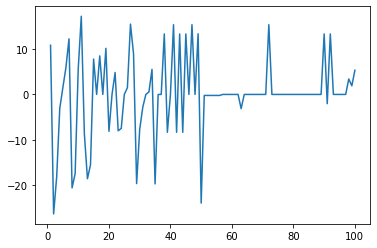

In [44]:
x = np.arange(1,len(total_pro)+1)
y = total_pro
plt.plot(x,y)
plt.show()